In [16]:
import os.path
import re
import os
import sys
import time
import stat
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot

In [ ]:
data_dir = "D:/DataFolder/OneDrive/Documents/Nov 2022 Election Data"
entries = (os.path.join(data_dir, f) \
           for f in os.listdir(data_dir) if re.match(r'.*11[0-9]{2}22.*xlsx', f))

file_processed_pair = []
registered = 0
rv_sheet = "Registered Voters"
rv_col_list = "A:C"
rv_col_names =  ["precinct", "registered", "counted" ]
rv_col_types = {"precinct":int, "registered":int, "counted":int}
for ent in entries :
    with open(ent,"rb") as f:
        rv = pd.read_excel(f, engine='openpyxl',sheet_name = rv_sheet,
                            names = rv_col_names, usecols=rv_col_list, 
                            header=None, skiprows=1, nrows=754,
                            dtype=rv_col_types).set_index("precinct")\
            .query("precinct > 3600 and precinct < 3700")
        s = rv.counted.sum()
        file_processed_pair.append((s, ent))
        registered = rv.registered.sum()
sorted(file_processed_pair, key=lambda fp : fp[0])
processed = [fp[0] for fp in file_processed_pair]

#for p in processed_file_pair:
#    print(f"{p[1]} has {p[0]} processed ballots")
#print(processed)

In [ ]:
cup_sheet = "75"
col_list = "A,E,H,K,N,Q,T,W,Z"
candidates = ["cb", "lc", "mc", "gt", "ss", "ys", "sm", "jf" ]
names = [ "precinct" ] + candidates
votes = {}
for c in candidates :
    votes[c] = []
dtype_dict = { "precinct": int, "cb": int, "lc": int, "mc" :int, "gt":int, "ss":int, "ys":int, "sm":int, "jf": int }
for wb in processed_file_pair :
    with open(wb[1], "rb") as f:
        df = pd.read_excel(f, sheet_name=cup_sheet, skiprows=3, nrows=19, usecols=col_list,  names=names,header=None, dtype=dtype_dict).set_index("precinct")
        for k in df.columns:
            votes[k].append(df[k].sum())
#print(votes)
#print(processed)
#print(registered)

Index(['cb', 'lc', 'mc', 'gt', 'ss', 'ys', 'sm', 'jf'], dtype='object')


<AxesSubplot:title={'center':'Current votes of candidates'}>

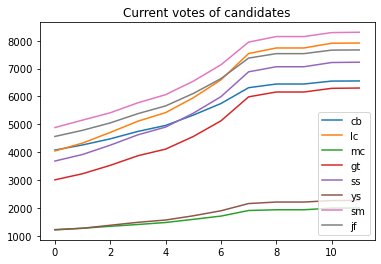

In [ ]:
# if we want to remove the two candidates "MC" and "YS" 
#vdf = pd.DataFrame(votes).drop(["mc","ys"], axis=1)
vdf = pd.DataFrame(votes)
print(vdf.columns)
vdf.plot(title="Current votes of candidates")

            cb     lc    mc     gt     ss    ys     sm     jf
turnout                                                      
32.47%    4076   4044  1221   3008   3682  1209   4885   4565
34.21%    4260   4328  1269   3227   3918  1269   5152   4786
36.63%    4479   4710  1339   3528   4252  1376   5416   5051
39.39%    4746   5113  1404   3873   4624  1482   5774   5384
41.63%    4960   5421  1475   4110   4902  1564   6065   5662
45.50%    5331   5953  1589   4563   5399  1716   6549   6108
50.03%    5747   6597  1705   5125   5993  1896   7138   6641
56.78%    6316   7542  1906   5987   6886  2156   7953   7379
58.25%    6448   7742  1933   6161   7068  2210   8152   7539
58.25%    6448   7742  1933   6161   7068  2210   8152   7539
59.48%    6553   7912  1991   6293   7220  2263   8294   7665
59.58%    6558   7920  1994   6304   7231  2268   8307   7672
60.00%    6613   7995  1993   6361   7295  2281   8367   7742
65.00%    7068   8702  2134   6970   7948  2476   8996   8315
70.00%  

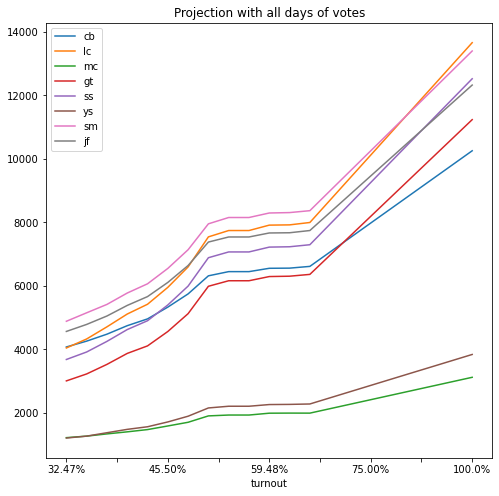

In [26]:
cur_turnout_pct = [ f"{((i * 100)/registered):.2f}%" for i in processed ]
turnout_pct_predict = [ "60.00%", "65.00%", "70.00%", "75.00%", "80.00%", "85.00%", "90.00%", "95.00%", "100.0%" ]
turnout_pct = cur_turnout_pct + turnout_pct_predict
projected_ballots = [ int(registered * float(k.replace("%","")) / 100.0) for k in turnout_pct_predict ]
to_predict = np.array(projected_ballots).reshape(-1,1)
new_votes = {}

for k in vdf.columns:
    new_votes[k] = []
    new_votes[k] += votes[k]
    regr = LinearRegression()
    x = np.array(processed)
    y = vdf[k].to_numpy()
    regr.fit(x.reshape(-1,1), y)
    prediction = regr.predict(to_predict)
    for s in range(prediction.size) :
        new_votes[k].append(int(prediction[s]))
new_votes["turnout"] = turnout_pct
ndf = pd.DataFrame(new_votes).set_index("turnout")
print(ndf)
axes = ndf.plot(figsize=(8,8), kind="line", title="Projection with all days of votes")


            cb     lc    mc     gt     ss    ys     sm     jf
turnout                                                      
45.50%    5331   5953  1589   4563   5399  1716   6549   6108
50.03%    5747   6597  1705   5125   5993  1896   7138   6641
56.78%    6316   7542  1906   5987   6886  2156   7953   7379
58.25%    6448   7742  1933   6161   7068  2210   8152   7539
58.25%    6448   7742  1933   6161   7068  2210   8152   7539
59.48%    6553   7912  1991   6293   7220  2263   8294   7665
59.58%    6558   7920  1994   6304   7231  2268   8307   7672
60.00%    6613   7995  1993   6361   7295  2281   8367   7742
65.00%    7068   8702  2134   6970   7948  2476   8996   8315
70.00%    7523   9410  2275   7579   8601  2671   9624   8887
75.00%    7978  10117  2416   8188   9254  2866  10252   9460
80.00%    8433  10825  2557   8797   9908  3061  10881  10032
85.00%    8888  11532  2698   9406  10561  3256  11509  10605
90.00%    9343  12240  2839  10015  11214  3450  12138  11177
95.00%  

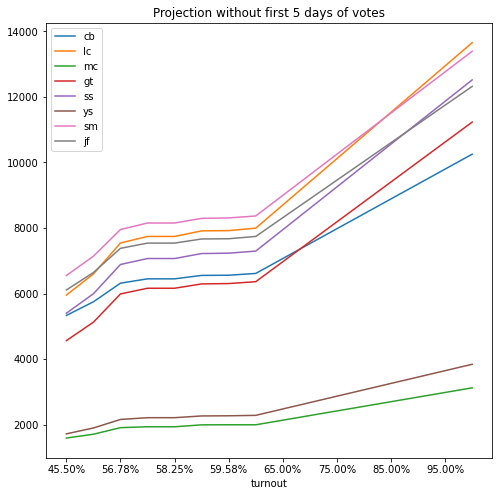

In [ ]:
n_processed = processed[5:]
cur_turnout_pct = [ f"{((i * 100)/registered):.2f}%" for i in n_processed ]
turnout_pct_predict = [ "60.00%", "65.00%", "70.00%", "75.00%", "80.00%", "85.00%", "90.00%", "95.00%", "100.0%" ]
turnout_pct = cur_turnout_pct + turnout_pct_predict
projected_ballots = [ int(registered * float(k.replace("%","")) / 100.0) for k in turnout_pct_predict ]
to_predict = np.array(projected_ballots).reshape(-1,1)
new_votes = {}
for k in vdf.columns:
    new_votes[k] = []
    new_votes[k] += votes[k][5:]
    regr = LinearRegression()
    x = np.array(processed)
    y = vdf[k].to_numpy()
    regr.fit(x.reshape(-1,1), y)
    prediction = regr.predict(to_predict)
    for s in range(prediction.size) :
        new_votes[k].append(int(prediction[s]))
new_votes["turnout"] = turnout_pct
ndf = pd.DataFrame(new_votes).set_index("turnout")
print(ndf)
axes = ndf.plot(figsize=(8,8), kind="line", title="Projection without first 5 days of votes")

In [ ]:
# For copying to other programs for further analysis
ndf.T

turnout,45.50%,50.03%,56.78%,58.25%,58.25%,59.48%,59.58%,60.00%,65.00%,70.00%,75.00%,80.00%,85.00%,90.00%,95.00%,100.0%
cb,5331,5747,6316,6448,6448,6553,6558,6613,7068,7523,7978,8433,8888,9343,9798,10253
lc,5953,6597,7542,7742,7742,7912,7920,7995,8702,9410,10117,10825,11532,12240,12948,13656
mc,1589,1705,1906,1933,1933,1991,1994,1993,2134,2275,2416,2557,2698,2839,2980,3121
gt,4563,5125,5987,6161,6161,6293,6304,6361,6970,7579,8188,8797,9406,10015,10624,11233
ss,5399,5993,6886,7068,7068,7220,7231,7295,7948,8601,9254,9908,10561,11214,11867,12520
ys,1716,1896,2156,2210,2210,2263,2268,2281,2476,2671,2866,3061,3256,3450,3645,3840
sm,6549,7138,7953,8152,8152,8294,8307,8367,8996,9624,10252,10881,11509,12138,12766,13395
jf,6108,6641,7379,7539,7539,7665,7672,7742,8315,8887,9460,10032,10605,11177,11750,12322
